In [1]:
%pip install -q transformers datasets pytorch-lightning optuna optuna-integration wandb

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from typing import Any, Dict
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import optuna
from optuna.integration import PyTorchLightningPruningCallback

import wandb
from pytorch_lightning.loggers import WandbLogger

# Set random seeds for reproducibility
pl.seed_everything(42, workers=True)



Seed set to 42


42

In [3]:
class BoolQDataset(Dataset):
    def __init__(self, data: Dict[str, Any], tokenizer: AutoTokenizer, max_length: int = 512):
        """
        Args:
            data: Dictionary containing the text and labels.
            tokenizer: Pretrained tokenizer for text processing.
            max_length: Maximum token sequence length.
        """
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self) -> int:
        return len(self.data["question"])

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        # Get question and passage
        question = self.data["question"][idx]
        passage = self.data["passage"][idx]
        label = self.data["answer"][idx]

        # Tokenize
        encoded = self.tokenizer(
            question,
            passage,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )

        # Correctness tests for tokenization
        assert encoded["input_ids"].shape[-1] <= self.max_length, "Token length exceeds max_length!"
        assert encoded["input_ids"].shape == encoded["attention_mask"].shape, "Mismatch in token shapes!"

        return {
            "input_ids": encoded["input_ids"].squeeze(0),  # Remove batch dimension
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.float),  # Float for binary classification
        }

In [4]:
class BoolQDataModule(pl.LightningDataModule):
    def __init__(self, tokenizer_name: str, batch_size: int = 16, max_length: int = 512):
        """
        Args:
            tokenizer_name: Name of the pretrained tokenizer.
            batch_size: Number of samples per batch.
            max_length: Maximum sequence length.
        """
        super().__init__()
        self.tokenizer_name = tokenizer_name
        self.batch_size = batch_size
        self.max_length = max_length

    def prepare_data(self) -> None:
        # Load dataset
        # Loading the dataset based on the given splits
        self.train_data = load_dataset("google/boolq", split="train[:-1000]")
        self.validation_data = load_dataset("google/boolq", split="train[-1000:]")
        self.test_data = load_dataset("google/boolq", split="validation")

    def setup(self, stage: str = None) -> None:
        # Initialize tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(self.tokenizer_name)

        # Create datasets
        self.train_dataset = BoolQDataset(self.train_data, self.tokenizer, self.max_length)
        self.val_dataset = BoolQDataset(self.validation_data, self.tokenizer, self.max_length)
        self.test_dataset = BoolQDataset(self.test_data, self.tokenizer, self.max_length)

        # Correctness tests for dataset splits
        assert len(self.train_dataset) > 0, "Train dataset is empty!"
        assert len(self.val_dataset) > 0, "Validation dataset is empty!"
        assert len(self.test_dataset) > 0, "Test dataset is empty!"

    def train_dataloader(self) -> DataLoader:
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self) -> DataLoader:
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

# Initialize DataModule
data_module = BoolQDataModule(tokenizer_name="bert-large-cased", batch_size=16)

# Prepare and test data loading
data_module.prepare_data()
data_module.setup()

# Correctness test for DataLoader
for batch in data_module.train_dataloader():
    assert batch["input_ids"].shape[0] == 16, "Batch size mismatch!"
    print(f"Batch loaded successfully with shape: {batch['input_ids'].shape}")
    break



Batch loaded successfully with shape: torch.Size([16, 512])


In [5]:
class BoolQClassifier(pl.LightningModule):
    def __init__(self, model_name: str, learning_rate: float = 1e-5, hidden_dim: int = 256, dropout_rate: float = 0.3):
        super(BoolQClassifier, self).__init__()
        self.save_hyperparameters()
        self.bert = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        self.loss_fn = nn.BCELoss()

        # Storage for test metrics
        self.test_preds = []
        self.test_labels = []

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        logits = self.classifier(cls_output)
        return logits.squeeze(-1)

    def training_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> torch.Tensor:
        logits = self(batch['input_ids'], batch['attention_mask'])
        loss = self.loss_fn(logits, batch['label'])
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> Dict[str, Any]:
        logits = self(batch['input_ids'], batch['attention_mask'])
        loss = self.loss_fn(logits, batch['label'])
        preds = (logits > 0.5).float()
        acc = (preds == batch['label']).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return {'val_loss': loss, 'val_acc': acc}

    def test_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> Dict[str, Any]:
        logits = self(batch['input_ids'], batch['attention_mask'])
        loss = self.loss_fn(logits, batch['label'])
        preds = (logits > 0.5).float()

        # Store predictions and labels for confusion matrix
        self.test_preds.extend(preds.cpu().numpy())
        self.test_labels.extend(batch['label'].cpu().numpy())

        acc = (preds == batch['label']).float().mean()

        # Log test metrics
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)

        return {'test_loss': loss, 'test_acc': acc}

    def on_test_epoch_end(self) -> None:
        # Compute confusion matrix
        cm = confusion_matrix(self.test_labels, self.test_preds)
        
        # Plot confusion matrix
        fig, ax = plt.subplots(figsize=(5, 5))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap=plt.cm.Blues, ax=ax)
        plt.title("Test Confusion Matrix")

        # Log confusion matrix to WandB
        wandb.log({"confusion_matrix": wandb.Image(fig)})

        # Clear storage
        self.test_preds.clear()
        self.test_labels.clear()

    

    def configure_optimizers(self) -> torch.optim.Optimizer:
        """
        Configure optimizers with different learning rates for the Transformer and classifier layers.
        """
        # Separate parameter groups
        transformer_params = list(self.bert.parameters())
        classifier_params = list(self.classifier.parameters())
    
        # Define learning rates
        transformer_lr = self.hparams.learning_rate  # Base learning rate
        classifier_lr = self.hparams.learning_rate * 10  # Higher learning rate for classifier
    
        # Create parameter groups
        optimizer = torch.optim.AdamW([
            {'params': transformer_params, 'lr': transformer_lr},
            {'params': classifier_params, 'lr': classifier_lr}
        ])
    
        return optimizer




In [6]:
BATCH_SIZE: int = 12

# WandB Logger initialization
def get_wandb_logger(run_name: str, group_name: str, hyperparameters: dict):
    return WandbLogger(
        project="nlp-p4-pretrained_transformers",  # Replace with your WandB project name
        name=run_name,
        group=group_name,
        log_model=True
    )

# Custom WandB Callback for Optuna Integration
class CustomWandbLoggingCallback(pl.Callback):
    def __init__(self, log_interval: int = 10):
        self.log_interval = log_interval

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if (batch_idx + 1) % self.log_interval == 0:
            metrics = trainer.callback_metrics
            wandb.log({
                "train_loss": metrics.get("train_loss", None),
                "train_acc": metrics.get("train_acc", None),
            })

    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        wandb.log({
            "val_loss": metrics.get("val_loss_epoch", None),
            "val_acc": metrics.get("val_acc_epoch", None),
        })

# Helper Function to Format Run Name
def format_run_name(hyperparams: dict) -> str:
    return "_".join([f"{key[:2]}_{val}" for key, val in hyperparams.items()])

# Manual Training
def train_manual():
    # Hyperparameters
    hyperparameters = {
        "learning_rate": 2e-5,
        "hidden_dim": 256,
        "dropout_rate": 0.3,
        "batch_size": BATCH_SIZE
    }

    # Run Name
    run_name = format_run_name(hyperparameters)

    # WandB Logger
    wandb_logger = get_wandb_logger(run_name, "manual_training", hyperparameters)

    # Initialize DataModule
    data_module = BoolQDataModule(
        tokenizer_name="bert-large-cased", 
        batch_size=hyperparameters["batch_size"]
    )

    # Initialize Model
    model = BoolQClassifier(
        model_name="bert-large-cased",
        learning_rate=hyperparameters["learning_rate"],
        hidden_dim=hyperparameters["hidden_dim"],
        dropout_rate=hyperparameters["dropout_rate"]
    )

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
    checkpoint = ModelCheckpoint(monitor='val_acc', mode='max', save_top_k=1, filename='best_model')

    # Trainer
    trainer = Trainer(
        max_epochs=100,
        callbacks=[early_stopping, checkpoint, CustomWandbLoggingCallback()],
        accelerator='gpu',
        devices=1,
        logger=wandb_logger
    )

    # Train
    trainer.fit(model, datamodule=data_module)

# Optuna Objective with WandB Logging
def objective(trial: optuna.Trial) -> float:
    # Suggest hyperparameters
    hyperparameters = {
        "learning_rate": trial.suggest_loguniform('learning_rate', 1e-6, 1e-4),
        "hidden_dim": trial.suggest_int('hidden_dim', 128, 512, step=64),
        "dropout_rate": trial.suggest_uniform('dropout_rate', 0.1, 0.5),
        "batch_size": BATCH_SIZE
    }

    # Run Name
    run_name = format_run_name(hyperparameters)

    # WandB Logger
    wandb_logger = get_wandb_logger(run_name, "optuna_testing", hyperparameters)

    # Initialize DataModule
    data_module = BoolQDataModule(
        tokenizer_name="bert-large-cased", 
        batch_size=hyperparameters["batch_size"]
    )

    # Initialize Model
    model = BoolQClassifier(
        model_name="bert-large-cased",
        learning_rate=hyperparameters["learning_rate"],
        hidden_dim=hyperparameters["hidden_dim"],
        dropout_rate=hyperparameters["dropout_rate"]
    )

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
    checkpoint = ModelCheckpoint(monitor='val_acc', mode='max', save_top_k=1, filename='best_model')
    pruning_callback = PyTorchLightningPruningCallback(trial, monitor='val_loss')

    # Trainer
    trainer = Trainer(
        max_epochs=100,
        callbacks=[early_stopping, checkpoint, pruning_callback, CustomWandbLoggingCallback()],
        accelerator='gpu',
        devices=1,
        logger=wandb_logger
    )

    # Train
    trainer.fit(model, datamodule=data_module)

    # Retrieve best score
    return trainer.callback_metrics['val_acc'].item()

# Optuna Study
def run_optuna():
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)

    # Best Hyperparameters
    best_params = study.best_params
    print(f"Best hyperparameters: {best_params}")

# Example Execution
# Uncomment one of the following to run
train_manual()
# run_optuna()


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: aintnoair. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | bert       | BertModel  | 333 M  | eval 
1 | classifier | Sequential | 262 K  | train
2 | loss_fn    | BCELoss    | 0      | train
--------------------------------------------------
333 M     Trainable params
0         Non-trainable params
333 M     Total params
1,335.368 Total estimated model params size (MB)
7         Modules in train mode
444       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: aintnoair. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7262997031211853
        test_loss           0.9438613653182983
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁
test_acc,▁
test_loss,▁
trainer/global_step,▁▁
epoch,0
test_acc,0.7263
test_loss,0.94386
trainer/global_step,0


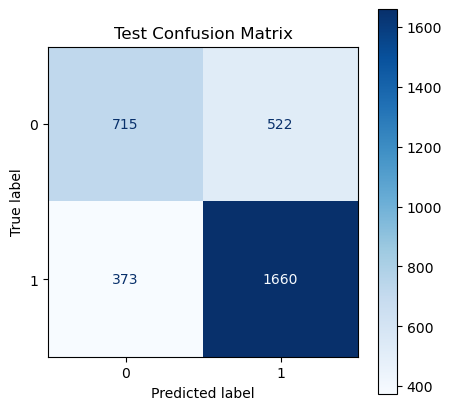

In [6]:
# Define paths and load model from checkpoint
base_path = Path("nlp-p4-pretrained_transformers/nlfg3sfr/checkpoints")
run_name = "best_model"
file_path = base_path / (run_name + ".ckpt")

# Initialize WandB logger for evaluation
wandb_logger = WandbLogger(project="nlp-p4-pretrained_transformers", name=run_name, group="evaluation")

# Load the model from the checkpoint
model = BoolQClassifier.load_from_checkpoint(file_path)

# Initialize DataModule for testing
data_module = BoolQDataModule(tokenizer_name="bert-large-cased", batch_size=32)
data_module.prepare_data()
data_module.setup()

# Initialize the trainer for testing
trainer = pl.Trainer(logger=wandb_logger)

# Run testing on the test set
trainer.test(model, dataloaders=data_module.test_dataloader())

# Finish WandB session
wandb.finish()
